In [62]:
import os
import pandas as pd
import cv2
import numpy as np
import math
import xml.dom.minidom
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from PIL import Image
from glob import glob

In [63]:
# Directories and create folders

folder = "57_1243501"
analysis_dir = "../../../Outputs/ML_training/" + folder + "/analysis/"
xml_dir = "../../../Outputs/ML_training/" + folder + "/processed_marks/page_xml/*"
reg_dir = "../../../Outputs/ML_training/" + folder + "/model_output_regions/"
xmls = glob(xml_dir)

In [64]:
# Extract Groundtruth data

# Load up the markup co-ordinates
# Load the ground truth csv file
via_export = pd.read_csv("../../mark_markup/via_export_csv.csv")
factor = 1
# Create the empty arrays
gtruth = []
page = []
regions = []
curname = ""
# Cycle through each instance of a mark
for x in range(via_export.shape[0]):
    
    # Extract the file name and region properties
    data = via_export.iloc[x]
    
    if data.filename[:-4] == curname:
        
        # reg_properties = [x,y,width,height] where x,y are the bottom left co-ordinates
        reg_properties = []
        temp_shape_data = data.region_shape_attributes[1:-1].split(',')

        # Check that the image actually has a reg
        if len(temp_shape_data) < 5:
            continue
        else:
            for y in range(1,5):
                value = temp_shape_data[y].split(':')

                # Take into account the images have been resized and floor the values
                reg_properties.append(math.floor(int(value[1])*factor))

            # Append new region to regions list
            regions.append(reg_properties)
        
        if x == via_export.shape[0]-1:
            page.append(regions)
            gtruth.append(page)
        
    else:
        page.append(regions)
        gtruth.append(page)
        page = []
        regions = []
        temp_name = data.filename.split('.')
        curname = temp_name[0]
        page.append(curname)
        page.append(data.region_count)

        # reg_properties = [x,y,width,height] where x,y are the bottom left co-ordinates
        reg_properties = []
        temp_shape_data = data.region_shape_attributes[1:-1].split(',')

        # Check that the image actually has a reg
        if len(temp_shape_data) < 5:
            continue
        else:
            for y in range(1,5):
                value = temp_shape_data[y].split(':')

                # Take into account the images have been resized and floor the values
                reg_properties.append(math.floor(int(value[1])*factor))

            # Append new region to regions list
            regions.append(reg_properties)
            if x == via_export.shape[0]-1:
                page.append(regions)
                gtruth.append(page)
            
gtruth.pop(0)

[[]]

In [65]:
# Check Groundtruth collected properly

c = 0
ok = True
for page in gtruth:
    print("\nThe filename: " + page[0])
    print("The file should have " + str(page[1]) + " regions")
    print("It has " + str(len(page[2])) + " regions\n")
    
    print(page)
    
    c = c + len(page[2])
    if page[1] != len(page[2]):
        ok = False
    else:
        continue
    
print("The total number of regions is " + str(c))
print("The CSV was processed properly: " + str(ok))


The filename: 94_20_0026
The file should have 4 regions
It has 4 regions

['94_20_0026', 4, [[616, 6103, 336, 182], [611, 6329, 402, 154], [726, 6476, 198, 70], [719, 6259, 180, 70]]]

The filename: 94_20_0027
The file should have 19 regions
It has 19 regions

['94_20_0027', 19, [[644, 704, 187, 171], [881, 875, 237, 171], [649, 1013, 231, 187], [936, 1183, 149, 187], [671, 1381, 220, 176], [969, 1530, 264, 176], [660, 1701, 275, 165], [870, 1888, 187, 154], [622, 2053, 264, 171], [897, 2207, 198, 143], [682, 2361, 187, 171], [655, 3071, 358, 182], [660, 3610, 341, 165], [671, 3803, 352, 165], [710, 4139, 286, 198], [671, 4353, 187, 198], [660, 4827, 198, 215], [682, 5355, 319, 209], [671, 5861, 314, 242]]]

The filename: 94_20_0028
The file should have 10 regions
It has 10 regions

['94_20_0028', 10, [[638, 996, 264, 171], [611, 1216, 286, 149], [578, 1381, 308, 154], [583, 1866, 237, 209], [633, 2680, 171, 242], [594, 3049, 286, 209], [578, 3946, 281, 220], [605, 4452, 275, 242], [5

In [66]:
# Check the files in xml directory

for page in xmls:
    print(page)
    
print(len(xmls))

../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/113_21_0057.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/114_7_0076.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_11_0076.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/114_7_0078.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_6_0038.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_11_0105.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_11_0117.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/94_20_0082.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_11_0077.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/114_7_0077.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/105_11_0103.xml
../../../Outputs/ML_training/57_1243501/processed_marks/page_xml/94_20_0059.xml
../../../Outputs/ML_training/57_12

In [67]:
# Extract model output data from XMLs (XML has the coordinates as x1,y1 x2,y2 x3,y3 x4,y4)
                                                                # (bl, br, tr, tl)

output = []

for page in xmls:

    data = []
    regions = []    
    doc = xml.dom.minidom.parse(page)
    
    name = doc.getElementsByTagName("Page")
    print("\nPage being analysed is " + name[0].getAttribute("imageFilename"))
    data.append(name[0].getAttribute("imageFilename")[:-4])
    
    Nodelist = doc.getElementsByTagName('Coords')
    
    for node in Nodelist:
        coords = []
        coordsTemp = node.getAttribute("points")
        coordsTemp = coordsTemp.split(' ')
        for x in coordsTemp:
            temp = x.split(',')
            coords.append((int(temp[0]),int(temp[1])))

        regions.append(coords)
        
    data.append(regions)
    output.append(data)

print("")
print(len(output))


Page being analysed is 113_21_0057.png

Page being analysed is 114_7_0076.png

Page being analysed is 105_11_0076.png

Page being analysed is 114_7_0078.png

Page being analysed is 105_6_0038.jpg

Page being analysed is 105_11_0105.png

Page being analysed is 105_11_0117.png

Page being analysed is 94_20_0082.jpg

Page being analysed is 105_11_0077.png

Page being analysed is 114_7_0077.png

Page being analysed is 105_11_0103.png

Page being analysed is 94_20_0059.jpg

Page being analysed is 105_11_0099.png

13



Creation of the directory Crop analysis failed

Analysing 113_21_0057
Loading output
Loading Gtruth
Calculating the # of missed marks
0 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
1 are not marks

Creation of the directory Crop analysis failed

Analysing 114_7_0076
Loading output
Loading Gtruth
Calculating the # of missed marks


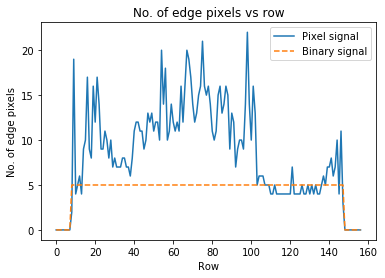

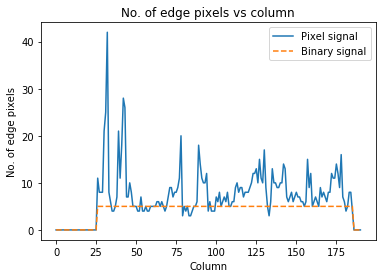

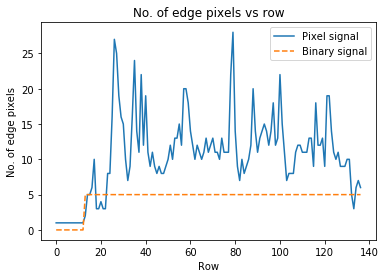

10
81.67350287120591
0 missed
1 cropped
11 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
1 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0076
Loading output
Loading Gtruth
Calculating the # of missed marks


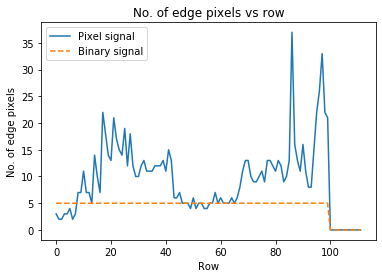

6
88.28125


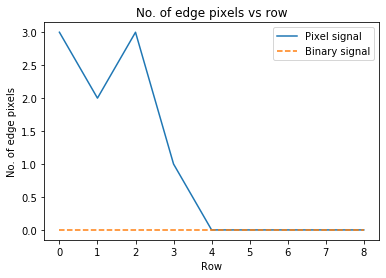

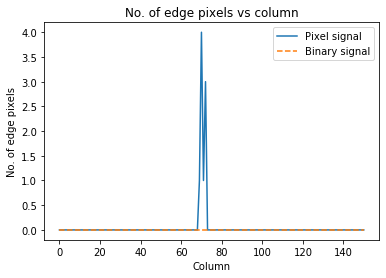

0 missed
1 cropped
14 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 114_7_0078
Loading output
Loading Gtruth
Calculating the # of missed marks


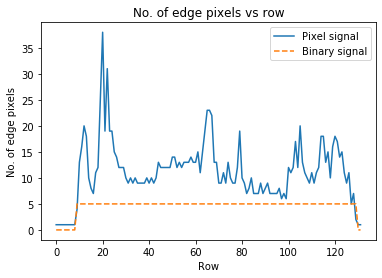

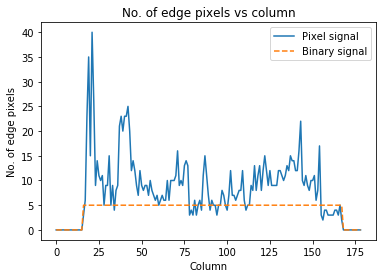

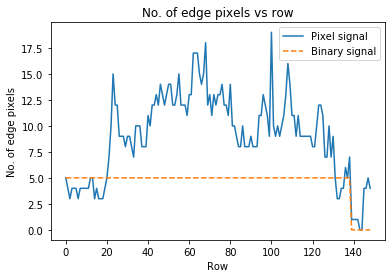

5
78.7112970711297


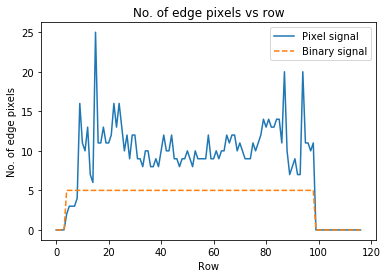

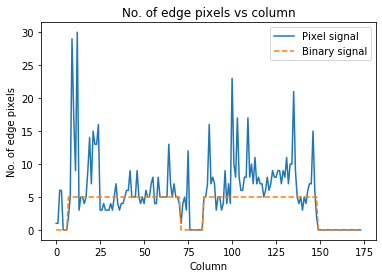

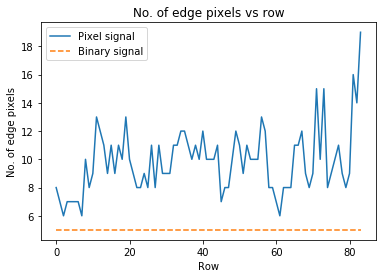

35
75.22123893805309


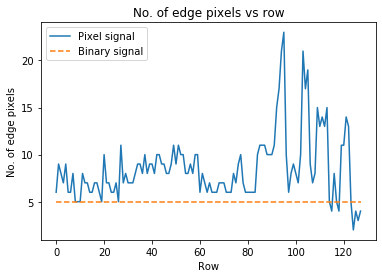

37
75.31239330829635
1 missed
3 cropped
34 successes

The total number of 70-89 crops: 3
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Successfully created the directory Crop analysis 

Analysing 105_6_0038
Loading output
Loading Gtruth
Calculating the # of missed marks
0 missed
0 cropped
0 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0105
Loading output
Loading Gtruth
Calculating the # of missed marks


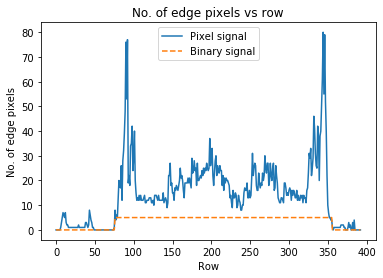

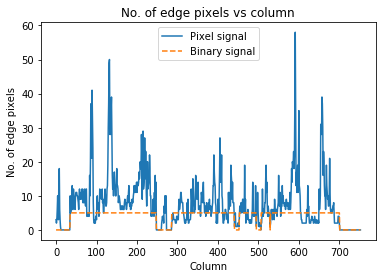

0 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0117
Loading output
Loading Gtruth
Calculating the # of missed marks


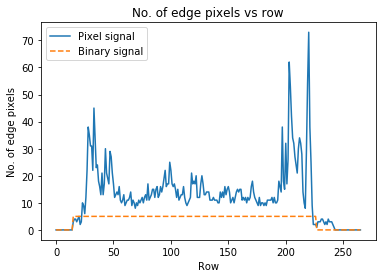

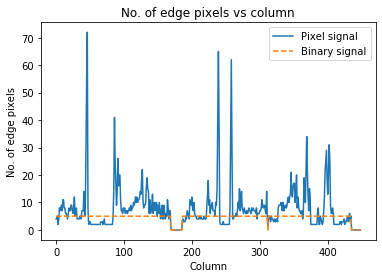

0
86.30163552912276
0 missed
1 cropped
0 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Successfully created the directory Crop analysis 

Analysing 94_20_0082
Loading output
Loading Gtruth
Calculating the # of missed marks
0 missed
0 cropped
0 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0077
Loading output
Loading Gtruth
Calculating the # of missed marks


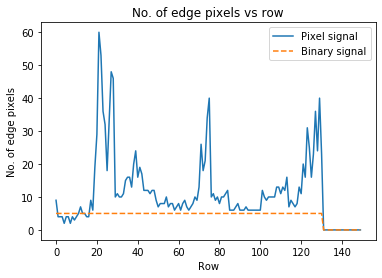

4
85.90785907859079


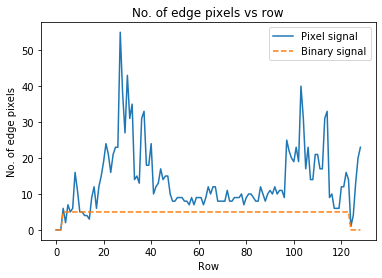

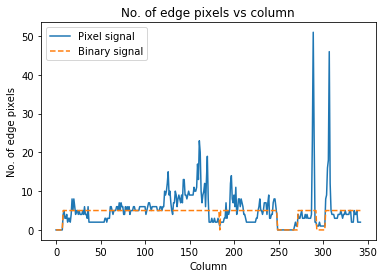

5
62.48602727475967
0 missed
2 cropped
5 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 1
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 114_7_0077
Loading output
Loading Gtruth
Calculating the # of missed marks


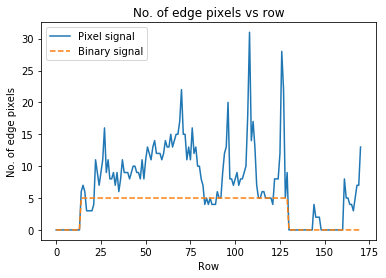

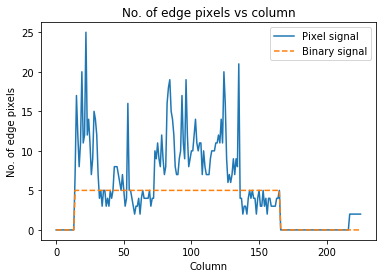

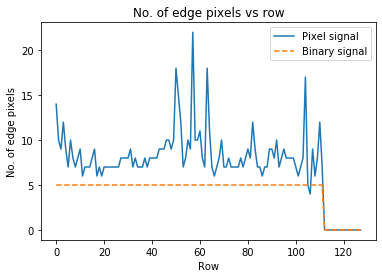

23
84.31372549019608
0 missed
1 cropped
26 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0103
Loading output
Loading Gtruth
Calculating the # of missed marks


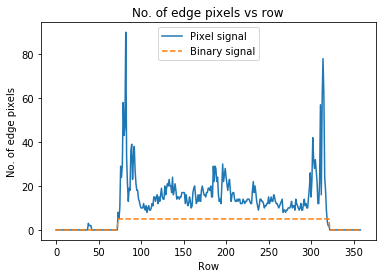

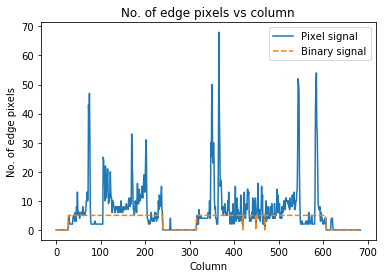

1 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks

Creation of the directory Crop analysis failed

Analysing 94_20_0059
Loading output
Loading Gtruth
Calculating the # of missed marks
0 missed
0 cropped
0 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
1 are not marks

Creation of the directory Crop analysis failed

Analysing 105_11_0099
Loading output
Loading Gtruth
Calculating the # of missed marks


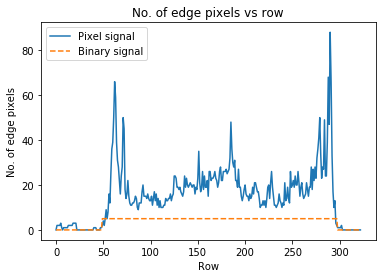

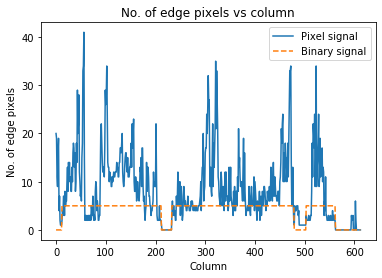

0 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0

Calculating the # of false marks
0 are not marks


In [68]:
# Calculation of metrics
gmetrics = []
ometrics = []
rmetrics = []
anomalies = []
gdb = []
odb = []
rdb = []
totalgm = 0
totalor = 0
crop70 = []
crop60 = []
crop1 = []

for x in output:
    
    crop7089 = 0
    crop6069 = 0
    crop159 = 0
    
    filename = x[0]
    regions = x[1]
    file_dir = "../../SampleSetsPNG/" + filename + ".png"
    crp_analysis_dir = reg_dir + filename + "/crop_analysis/"
    
    try:
        os.mkdir(crp_analysis_dir)
    except OSError:
        print ("\nCreation of the directory %s failed" % "Crop analysis")
    else:
        print ("\nSuccessfully created the directory %s " % "Crop analysis")
    
    print('\nAnalysing ' + filename)
    
    ogimg = cv2.imread(file_dir)
    img = cv2.cvtColor(ogimg, cv2.COLOR_BGR2GRAY)
    
    img = cv2.rectangle(img, (0,0), (img.shape[1], img.shape[0]), (0,0,0), -1)
    
    # Plotting the output
    print("Loading output")
    
    for region in regions:
        # NOTE rectangle uses BGR
        img = cv2.rectangle(img, region[3], region[1] , 1, -1)
    
    print("Loading Gtruth")
    # Find the index of the page in gtruth list
    index = 0
    for page in gtruth:
        if page[0] == filename:
            break
        index += 1
    
    # Add the ground truth to the analysis images
    # NOTE opencv uses BGR
    gregions = []
    if index == len(gtruth):
        # This is the case when the page has no merchant marks in the ground truth
        pass
    else:
        gregions = gtruth[index][2]
        for region in gregions:
            for x in range(region[0],region[0]+region[2]):
                for y in range(region[1],region[1]+region[3]):
                    img[y][x] += 2
                    
    totalgm += len(gregions)
    totalor += len(regions)
                    
    # Calculate the missing marks percentage (misses), successfully extracted (succ) and cropped (cropped)
    print("Calculating the # of missed marks")
    misses = 0
    count = 0
    cropped = 0
    succ = 0
    if index == len(gtruth):
        # This is the case when the page has no merchant marks in the ground truth
        pass
    else:
        for region in gregions:
            Tpos = 0
            overlap = []
            for x in range(region[0],region[0]+region[2]):
                for y in range(region[1],region[1]+region[3]):
                    if img[y][x] == 3:
                        Tpos += 1
                        overlap.append([y,x])
            
            percent = Tpos/(region[2]*region[3]) * 100

            #Check for a miss
            if percent == 0:
                misses += 1
            #First check for crop            
            elif percent <= 90:
                #Second Check (Veritcal Cropped)
                #Get the overlap area
                overlap = np.array(overlap)
                top = overlap.max(axis=0)[0]
                bottom = overlap.min(axis=0)[0]
                left = overlap.min(axis=0)[1]
                right = overlap.max(axis=0)[1]
                
                #Edge pixel analysis
                edges = cv2.Canny(ogimg,100,200)
                ecrop = edges[bottom:top, left:right]
                
                #The case where only 1 line of pixels overlap (Most liekly an accident, hence a miss)
                if ecrop.shape[0] == 0 or ecrop.shape[1] == 0:
                    misses += 1
                    continue
                
                #print("Analysing Gtruth region " + str(count))
                #print(ecrop.shape)
                cv2.imwrite(crp_analysis_dir + str(count) + '.png', ecrop)
                esig = np.sum(ecrop, axis=1)/255

                bin_sig = []
                peaks = []
                p = []
                #Check for peaks, form binary signal, store pixel values for peak and append to peaks.
                for n in range(len(esig)):
                    if esig[n] >= 2:
                        bin_sig.append(5)
                        p.append(n)
                        if n == len(esig)-1:
                            peaks.append(p)
                    else:
                        bin_sig.append(0)
                        if len(p) != 0:
                            peaks.append(p)
                            p = []
                        else:
                            continue

                # Filter signal (Remove unlikely peaks)
                indicies = []
                for x in range(len(peaks)):
                    peak = peaks[x]
                    if len(peak) < 15:
                        #print("Region " + str(x) + " needs to be removed")
                        for y in range(len(peak)):
                            bin_sig[peak[y]] = 0
                        indicies.append(x)
                    else:
                        continue
                        
                # Pop the false peaks from the largest index first
                indicies.reverse()
                for x in indicies:
                    peaks.pop(x)
                    
                plt.plot(esig, label="Pixel signal")
                plt.plot(bin_sig, label="Binary signal", linestyle="dashed")
                plt.xlabel("Row")
                plt.ylabel("No. of edge pixels")
                plt.legend()
                plt.title("No. of edge pixels vs row")
                plt.savefig(crp_analysis_dir + str(count) +  'v.svg')
                plt.show()
                
                if bin_sig[0] == 0 and bin_sig[-1] == 0:
                    #print("Need to check horizontal crop")
                    esig = np.sum(ecrop, axis=0)/255

                    bin_sig = []
                    peaks = []
                    p = []
                    #Check for peaks, form binary signal, store pixel values for peak and append to peaks.
                    for n in range(len(esig)):
                        if esig[n] >= 2:
                            bin_sig.append(5)
                            p.append(n)
                            if n == len(esig)-1:
                                peaks.append(p)
                        else:
                            bin_sig.append(0)
                            if len(p) != 0:
                                peaks.append(p)
                                p = []
                            else:
                                continue

                    # Filter signal (Remove unlikely peaks)
                    indicies = []
                    for x in range(len(peaks)):
                        peak = peaks[x]
                        if len(peak) < 15:
                            #print("Region " + str(x) + " needs to be removed")
                            for y in range(len(peak)):
                                bin_sig[peak[y]] = 0
                            indicies.append(x)
                        else:
                            continue

                    # Pop the false peaks from the largest index first
                    indicies.reverse()
                    for x in indicies:
                        peaks.pop(x)

                    plt.plot(esig, label="Pixel signal")
                    plt.plot(bin_sig, label="Binary signal", linestyle= "dashed")
                    plt.xlabel("Column")
                    plt.ylabel("No. of edge pixels")
                    plt.legend()
                    plt.title("No. of edge pixels vs column")
                    plt.savefig(crp_analysis_dir + str(count) +  'h.svg')
                    plt.show()
                    
                    if bin_sig[0] == 0 and bin_sig[-1] == 0:
                        succ += 1
                    else:
                        cropped += 1
                        print(count)
                        print(percent)
                        if percent < 60:
                            crop159 += 1
                        elif percent < 70:
                                crop6069 += 1
                        else:
                            crop7089 += 1
                    
                else:
                    cropped += 1
                    print(count)
                    print(percent)
                    if percent < 60:
                        crop159 += 1
                    elif percent < 70:
                        crop6069 += 1
                    else:
                        crop7089 += 1
                
            else:
                #print("Ground truth region " + str(count) +" extracted successfully")
                succ += 1
                    
            count += 1

    print(str(misses) + " missed")
    print(str(cropped) + " cropped")
    print(str(succ) + " successes")
    
    print("\nThe total number of 70-89 crops: "+ str(crop7089))
    print("The total number of 60-69 crops: "+ str(crop6069))
    print("The total number of 1-59 crops: "+ str(crop159))
    
    if cropped != 0:
        # Caculate the crop rate for each percentage wrt cropped images
        crop7089 = crop7089/cropped
        crop6069 = crop6069/cropped
        crop159 = crop159/cropped
    
        # store the crop statistics
        crop70.append(crop7089)
        crop60.append(crop6069)
        crop1.append(crop159)
    
    print("\nCalculating the # of false marks")
    # Calculate the accuracy (Whether the identified output region is a mark or not)
    correct = 0
    count = 0
    for region in regions:
        r = False
        for x in range(region[0][0],region[1][0]):
            for y in range(region[1][1],region[2][1]):
                if img[y][x] == 3:
                    r = True
        if r == True:
            correct += 1
        else:
            #print("Output Region " + str(count) + " is not a mark")
            pass
        count += 1
    print(str(len(regions) - correct) + " are not marks")
    
    # If there is no ground truth but a false detection
    if len(gregions) == 0 and len(regions) != 0:
        anomalies.append([filename])
        # store the rate metrics 
        rmetric = [succ, cropped, misses, correct]
        rmetrics.append(rmetric)
        # store the region metrics
        ometric = [correct/len(regions)]
        ometrics.append(ometric)
        odb.append([filename, ometric])
    
    # IF there is no ground truth and no detections
    elif len(gregions) == 0 and len(regions) == 0:
        anomalies.append([filename])
        # store the rate metics
        rmetric = [succ, cropped, misses, correct]
        rmetrics.append(rmetric)
        
    else:
        # create the metics
        gmetric = [succ/len(gregions), cropped/len(gregions), misses/len(gregions)]
        ometric = [correct/len(regions)]
        rmetric = [succ, cropped, misses, correct]
        
        #store the metics
        gmetrics.append(gmetric)
        ometrics.append(ometric)
        rmetrics.append(rmetric)
        
        # store the metrics to create a dict later
        gdb.append([filename, gmetric])
        odb.append([filename, ometric])
        
    rdb.append([filename, rmetric])

In [69]:
fname = []
success = []
cropped = []
missed = []
correct = []

# The success, cropped, misses
print("Total number of analysed pages: " + str(len(gdb)))
for page in gdb:
    print(page)
    fname.append(page[0])
    success.append(page[1][0])
    cropped.append(page[1][1])
    missed.append(page[1][2])

# Take an average of the success, cropped, misses
av = np.mean(gmetrics, axis=0)
fname.append("average")
success.append(round(av[0],3))
cropped.append(round(av[1],3))
missed.append(round(av[2],3))
print('The average success, cropped and miss rates are:' + str(av))

# Find out the crop percentages
print("\nThe 70-89 crops: "+ str(np.mean(crop70)))
print("The 60-69 crops: "+ str(np.mean(crop60)))
print("The 1-59 crops: "+ str(np.mean(crop1)))

db_dict = {
    "filename": fname,
    "success rate": success,
    "crop rate": cropped,
    "miss rate": missed
}

greg_analysis = pd.DataFrame(db_dict)
greg_analysis.to_csv(analysis_dir + "greg_analysis.csv")

fname = []
print("\nTotal number of analysed pages: " + str(len(odb)))
for page in odb:
    print(page)
    fname.append(page[0])
    correct.append(page[1])


av = np.mean(ometrics, axis=0)
fname.append("average")
correct.append(round(av[0],3))
# Take an average of the correct identification rate
print('The average success, cropped and miss rates are:' + str(av))

db_dict = {
    "filename": fname,
    "correct locating rate": correct
}

oreg_analysis = pd.DataFrame(db_dict)
oreg_analysis.to_csv(analysis_dir + "oreg_analysis.csv")

# The correct identification rate
print("\nThe anomalies are:")
print(anomalies)

Total number of analysed pages: 10
['113_21_0057', [1.0, 0.0, 0.0]]
['114_7_0076', [0.9166666666666666, 0.08333333333333333, 0.0]]
['105_11_0076', [0.9333333333333333, 0.06666666666666667, 0.0]]
['114_7_0078', [0.8947368421052632, 0.07894736842105263, 0.02631578947368421]]
['105_11_0105', [1.0, 0.0, 0.0]]
['105_11_0117', [0.0, 1.0, 0.0]]
['105_11_0077', [0.7142857142857143, 0.2857142857142857, 0.0]]
['114_7_0077', [0.9629629629629629, 0.037037037037037035, 0.0]]
['105_11_0103', [0.5, 0.0, 0.5]]
['105_11_0099', [1.0, 0.0, 0.0]]
The average success, cropped and miss rates are:[0.79219855 0.15516987 0.05263158]

The 70-89 crops: 0.9166666666666666
The 60-69 crops: 0.08333333333333333
The 1-59 crops: 0.0

Total number of analysed pages: 11
['113_21_0057', [0.5]]
['114_7_0076', [0.5]]
['105_11_0076', [1.0]]
['114_7_0078', [1.0]]
['105_11_0105', [1.0]]
['105_11_0117', [1.0]]
['105_11_0077', [1.0]]
['114_7_0077', [1.0]]
['105_11_0103', [1.0]]
['94_20_0059', [0.0]]
['105_11_0099', [1.0]]
The a

In [70]:
'''
# Overall data set - MM extraction metrics
# metric [#gregions, #succ, #cropped, #misses, #oregions, #correct]

s = 0
c = 0
m = 0
a = 0

print("The raw metrics")
for page in rdb:
    print(page)

print("Total # of gtruth regions")
totalgm = totalgm - len(anomalies)
print(totalgm)
print("Total # of output regions")
print(totalor)

for metric in rmetrics:
    s += metric[1]
    c += metric[2]
    m += metric[3]
    a += metric[5]
    
print("Overall test data set metrics:")
print(s/totalgm, c/totalgm, m/totalgm, a/totalor)
'''

'\n# Overall data set - MM extraction metrics\n# metric [#gregions, #succ, #cropped, #misses, #oregions, #correct]\n\ns = 0\nc = 0\nm = 0\na = 0\n\nprint("The raw metrics")\nfor page in rdb:\n    print(page)\n\nprint("Total # of gtruth regions")\ntotalgm = totalgm - len(anomalies)\nprint(totalgm)\nprint("Total # of output regions")\nprint(totalor)\n\nfor metric in rmetrics:\n    s += metric[1]\n    c += metric[2]\n    m += metric[3]\n    a += metric[5]\n    \nprint("Overall test data set metrics:")\nprint(s/totalgm, c/totalgm, m/totalgm, a/totalor)\n'